# Decoding Surface Code

In this experiment, we’ll use ``mdopt`` to decode the Surface Code. Hereafter, we assume an independent noise model as well as perfect syndrome measurements. We will create a Surface Code instance via the Hypergraph Product of two repetition codes. This example will be less pedagogical than the one with the Shor's code because we have already packaged all subroutines in a function. For a detailed overview of these subroutines the user is invited to read the Shor Code example as well as consult the appropriate code.

In [1]:
import numpy as np
from tqdm import tqdm
import qecstruct as qc
import qecsim.paulitools as pt

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter

from mdopt.mps.utils import marginalise, create_custom_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)
from examples.decoding.decoding import (
    apply_constraints,
    apply_bitflip_bias,
)
from examples.decoding.decoding import (
    decode_css,
    pauli_to_mps,
    css_code_checks,
    css_code_logicals,
    css_code_logicals_sites,
    css_code_constraint_sites,
    generate_pauli_error_string,
)

In [2]:
LATTICE_SIZE = 4
NUM_EXPERIMENTS = 50

SEED = 123
seed_seq = np.random.SeedSequence(SEED)

max_bond_dims = [256, 128, 64, 32, 16, 8]
error_rates = np.linspace(1e-2, 0.2, 10)
failures_statistics = {}

for CHI_MAX in max_bond_dims:
    print(f"CHI_MAX = {CHI_MAX}")
    for ERROR_RATE in tqdm(error_rates):
        failures = []

        for l in range(NUM_EXPERIMENTS):
            new_seed = seed_seq.spawn(1)[0]
            rng = np.random.default_rng(new_seed)
            random_integer = rng.integers(1, 10**8 + 1)
            SEED = random_integer

            rep_code = qc.repetition_code(LATTICE_SIZE)
            surface_code = qc.hypergraph_product(rep_code, rep_code)

            error = generate_pauli_error_string(
                len(surface_code), ERROR_RATE, seed=SEED
            )
            error = pauli_to_mps(error)

            _, success = decode_css(
                code=surface_code,
                error=error,
                chi_max=CHI_MAX,
                bias_type="Depolarizing",
                bias_prob=ERROR_RATE,
                renormalise=True,
                silent=True,
                contraction_strategy="Optimised",
            )

            failures.append(1 - success)

        failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = failures

CHI_MAX = 256


100%|██████████| 10/10 [8:47:29<00:00, 3165.00s/it] 


CHI_MAX = 128


 10%|█         | 1/10 [13:13<1:59:00, 793.44s/it]

 ** On entry to DLASCL parameter number  4 had an illegal value


100%|██████████| 10/10 [2:14:44<00:00, 808.49s/it] 


CHI_MAX = 64


100%|██████████| 10/10 [35:35<00:00, 213.59s/it]


CHI_MAX = 32


100%|██████████| 10/10 [07:41<00:00, 46.16s/it]


CHI_MAX = 16


100%|██████████| 10/10 [01:36<00:00,  9.68s/it]


CHI_MAX = 8


100%|██████████| 10/10 [01:05<00:00,  6.55s/it]


In [3]:
failure_rates = {}
error_bars = {}

for CHI_MAX in max_bond_dims:
    for ERROR_RATE in error_rates:
        failure_rates[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = np.mean(
            failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
        )
        error_bars[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = (
            np.std(failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE])
            * 1.96  # Standart error of the mean with 95% confidence interval
            / NUM_EXPERIMENTS
        )

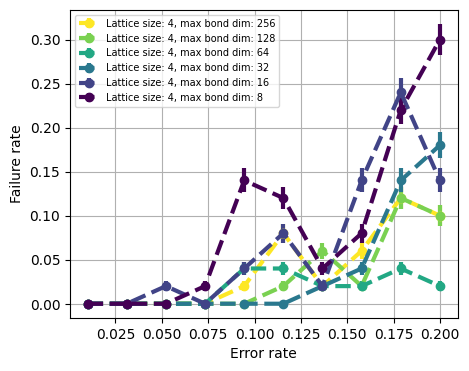

In [4]:
plt.figure(figsize=(5, 4))

green_cmap = matplotlib.colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(max_bond_dims) - 1)

for index, CHI_MAX in enumerate(max_bond_dims):
    plt.errorbar(
        error_rates,
        [
            failure_rates[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
            for ERROR_RATE in error_rates
        ],
        yerr=[
            error_bars[LATTICE_SIZE, CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates
        ],
        fmt="o--",
        label=f"Lattice size: {LATTICE_SIZE}, max bond dim: {CHI_MAX}",
        linewidth=3,
        color=green_cmap(norm(index)),
    )

plt.legend(fontsize=7)
plt.xlabel("Error rate")
plt.ylabel("Failure rate")
plt.grid()

plt.show()